In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import pandas as pd 
from pathlib import Path
from bioblp.data import COL_EDGE, COL_SOURCE, COL_TARGET

In [26]:
DATA_DIR = Path('../data')
SHARED_DIR = Path('/home/jovyan/workbench-shared-folder/bioblp/')
SHARED_DATA_DIR = SHARED_DIR.joinpath('data')
SHARED_MODELS_DIR = SHARED_DIR.joinpath('models/biokg')
BENCHMARKS_DATA_DIR = SHARED_DATA_DIR.joinpath('benchmarks/transductive')

In [27]:
!ls {BENCHMARKS_DATA_DIR}/

ddi_efficacy.tsv  dep_fda_exp.tsv  phosphorylation.tsv
ddi_minerals.tsv  dpi_fda.tsv


In [28]:
!ls {SHARED_MODELS_DIR}/best-vanilla-kge/

complex-q8laf0sn	 rotate-otxtubeb
complex-q8laf0sn.tar.gz  rotate-otxtubeb.tar.gz


## Load benchmark

In [29]:
dpi_benchmark_path = BENCHMARKS_DATA_DIR.joinpath('dpi_fda.tsv')
biokg_triples_dir = SHARED_DATA_DIR.joinpath('graph/biokg/training_triples')

In [ ]:
# sneak peek into benchmark data
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm.head(3)

,src,edg,tgt
0,DB01079,DPI,Q13639
1,DB00114,DPI,P20711
2,DB01158,DPI,P13637


In [30]:
# can run the following from cli, project root to create the preprocessed Benchmark dataset with negative samples
! python -m bioblp.benchmarking.preprocess --bm_data_path {dpi_benchmark_path} --num_negs_per_pos 50 --outdir /home/jovyan/workbench-shared-folder/bioblp/data --kg_triples_dir {biokg_triples_dir}


14:12:35 - INFO - __main__ - Generating negative samples corresponding to benchmark triples
Reconstructing all label-based triples. This is expensive and rarely needed.
14:12:36 - INFO - __main__ - Writing preprocessed data to /home/jovyan/workbench-shared-folder/bioblp/data/benchmarks/processed/dpi_fda_p2n-1-50.tsv
14:12:38 - INFO - __main__ - Done!



* [DB01079; Tegaserod](https://go.drugbank.com/drugs/DB01079)
Tegaserod is a serotonin-4 (5-HT4) receptor agonist indicated for the treatment of constipation predominant irritable bowel syndrome (IBS-C) specifically in women under the age of 65. There is currently no safety or efficacy data for use of tegaserol in men.

* https://www.uniprot.org/uniprotkb/Q13639/entry

In [31]:
dpi_drugs_unique = list(dpi_bm.src.unique())
dpi_prots_unique = list(dpi_bm.tgt.unique())
print(f'# total dpi instances (TP): {len(dpi_bm)}')
print(f'# Unique Drugs: {len(dpi_drugs_unique)}')
print(f'# Unique Proteins: {len(dpi_prots_unique)}')


# total dpi instances (TP): 18678
# Unique Drugs: 2167
# Unique Proteins: 2573


## Prepare Data for ML

This featurizes the training dataset (preprocessed benchmark dataset which includes negative samples) for the downstream DPI task, using a featurizer of choice.
Possible featurizing methods include KGEM (vanilla vs bioblp, etc), random noise embedders, or domain-knowledge based embeddings

In [36]:
model_dir = f'{SHARED_MODELS_DIR}/best-vanilla-kge/rotate-otxtubeb'
processed_bm_path = f'{SHARED_DATA_DIR}/benchmarks/processed/dpi_benchmark_p2n-1-10.tsv'
JOINT_TRANSFORM_OPERATOR = 'average'
processed_bm_path

'/home/jovyan/workbench-shared-folder/bioblp/data/benchmarks/processed/dpi_benchmark_p2n-1-10.tsv'

In [37]:
! python -m bioblp.benchmarking.featurize -i {processed_bm_path} -o {DATA_DIR}/features/ -t kgem -m {model_dir} -j {JOINT_TRANSFORM_OPERATOR} 

14:25:26 - INFO - __main__ - Loading trained model from /home/jovyan/workbench-shared-folder/bioblp/models/biokg/best-vanilla-kge/rotate-otxtubeb
14:25:27 - INFO - __main__ - Mapping entities to KG identifiers
14:25:27 - INFO - __main__ - Applying transformation function to retrieve joint encoding for entity pair
14:25:32 - INFO - __main__ - Saved featurized instances and correponding labels y to ../data/features/average/20221019-142528


## Train ML model for binary clf

In [44]:
xy_featurized_data_dir = f'{DATA_DIR}/features/average/20221019-142528'
out_clf_dir = f'{DATA_DIR}/benchmarks/models'
! ls {out_clf_dir}

1666182344-wyk4hj2v.csv  nested_cv_scores_1666182344.npy
1666184724-0a77ov0m.csv


In [49]:
! python -m bioblp.benchmarking.train --data_dir {xy_featurized_data_dir} --outdir {out_clf_dir} --inner_n_folds 2 --outer_n_folds 2 --candidate_algo_list RF LR

14:45:12 - INFO - __main__ - Starting model building script at 1666190712.953394.
14:45:12 - INFO - __main__ - Loading training data...
14:45:13 - INFO - __main__ - Resulting shapes X_train: (205458, 512), y_train: (205458,)
14:45:13 - INFO - __main__ - Counts in y_train: (array([0, 1]), array([186780,  18678]))
[I 2022-10-19 14:45:13,139] A new study created in memory with name: j93kyuxa-RF-0
/home/jovyan/BioBLP/bioblp/benchmarking/train.py:429: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandb_callback = WeightsAndBiasesCallback(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[CV] START .....................................................................
[CV] START .....................................................................


### older stuff

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=0, shuffle=True)

In [45]:
lr = LogisticRegression(max_iter=300)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=300)

In [48]:
# predictions
y_testpred = lr.predict(x_test)

In [49]:
# score
# Use score method to get accuracy of model
insample_acc= lr.score(x_train, y_train)
test_acc = lr.score(x_test, y_test)
print(f"Insample accuracy: {insample_acc}")
print(f"Test accuracy: {test_acc}")

Insample accuracy: 0.9551786795881284
Test accuracy: 0.953762289496739


#### confusion matrix

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [51]:
metrics.classification_report(y_test, y_testpred)

'              precision    recall  f1-score   support\n\n           0       0.97      0.98      0.97     18714\n           1       0.78      0.67      0.72      1832\n\n    accuracy                           0.95     20546\n   macro avg       0.87      0.83      0.85     20546\nweighted avg       0.95      0.95      0.95     20546\n'

In [52]:
print(metrics.classification_report(y_test, y_testpred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     18714
           1       0.78      0.67      0.72      1832

    accuracy                           0.95     20546
   macro avg       0.87      0.83      0.85     20546
weighted avg       0.95      0.95      0.95     20546



In [53]:
cm = metrics.confusion_matrix(y_test, y_testpred)
print(cm)

[[18363   351]
 [  599  1233]]


In [54]:
cm_best = metrics.confusion_matrix(y_test, y_testpred)
print(cm_best)

[[18363   351]
 [  599  1233]]


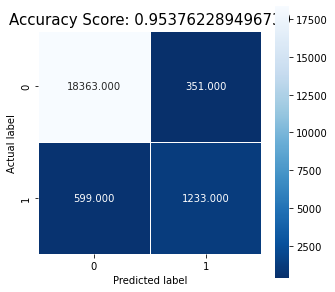

In [55]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_acc)
plt.title(all_sample_title, size = 15);

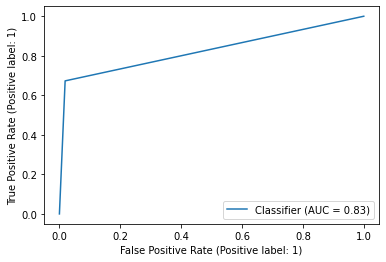

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_testpred)
plt.show()

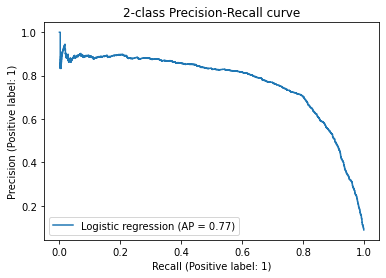

In [59]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr, x_test, y_test, name="Logistic regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")